In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from time import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_auc_score

In [2]:
from datetime import datetime

def mostrar_tiempo(df):    
    dic_events_time = {}
    person = ""
    rows = []
    compra = False
    for index, row in df.iterrows():
        if(person == ""):
            person = row["person"]
            last_event_time = row['timestamp']
            continue            
        if(row['event'] == 'conversion'):
            compra = True
        tiempo = (datetime.strptime(last_event_time,"%Y-%m-%d %H:%M:%S") \
                                - datetime.strptime(row['timestamp'],"%Y-%m-%d %H:%M:%S")).total_seconds()
        if(tiempo > 86400):
            last_event_time = row['timestamp']
        if (row['new_vs_returning'] == 'New' or row['new_vs_returning'] == 'Returning' or person != row["person"]):
            if(row['person'] != person):
                tiempo = 0
            rows.append([person,tiempo,row['timestamp'],compra])
            person = ""
            compra = False
    return pd.DataFrame(rows,columns=('person', 'time_event', 'timestamp','realizo_compra'))

In [3]:
datos = pd.read_csv("events_up_to_01062018.csv",low_memory=False)


In [4]:
datos.columns

Index(['timestamp', 'event', 'person', 'url', 'sku', 'model', 'condition',
       'storage', 'color', 'skus', 'search_term', 'staticpage',
       'campaign_source', 'search_engine', 'channel', 'new_vs_returning',
       'city', 'region', 'country', 'device_type', 'screen_resolution',
       'operating_system_version', 'browser_version'],
      dtype='object')

In [5]:
sistema_celulares = datos.loc[datos['device_type']=='Smartphone',['person','timestamp','operating_system_version']]\
                                    .sort_values(by=['person','timestamp'],ascending=False).drop_duplicates('person')

In [6]:
#sistema_celulares.operating_system_version.value_counts().sort_index(ascending=False)
sistema_celulares['operating_system_version'] = sistema_celulares.operating_system_version.str.split('.').str[0]

In [7]:
iOS = sistema_celulares.loc[sistema_celulares.operating_system_version.str.contains('iOS')]

In [8]:
iOS.operating_system_version.value_counts()

iOS 11    1111
iOS 10     407
iOS 9      153
iOS 7       46
iOS 8       10
iOS 6        2
Name: operating_system_version, dtype: int64

In [9]:
Android = sistema_celulares.loc[sistema_celulares.operating_system_version.str.contains('Android')]
Android.operating_system_version.value_counts()

Android 6     7448
Android 7     6049
Android 5     3367
Android 4     1596
Android 8      442
Android         27
Android 2        7
Android 3        2
Android 10       1
Name: operating_system_version, dtype: int64

In [10]:
def esViejo(celular):
    if (celular == "Android 4" or celular == "Android 2" or celular == "Android 3"):
        return 1
    else:
        return 0

In [11]:
sistema_celulares["celularViejo"] = sistema_celulares["operating_system_version"].apply(lambda x: esViejo(x))

In [12]:
sistema_celulares = sistema_celulares[["person", "celularViejo"]]

In [13]:
h = datos[['person','timestamp','event','new_vs_returning']]
h = h.sort_values(by=['person','timestamp'],ascending=False)
g = mostrar_tiempo(h)

In [14]:
g = g.sort_values(by='time_event',ascending=False)
g = g.loc[g['time_event']>0]

In [15]:
datos = pd.merge(datos,g,on=['person','timestamp'],how='left')

In [16]:
datos[['person','timestamp','time_event','event','new_vs_returning']].loc[datos['time_event']>0]

,person,timestamp,time_event,event,new_vs_returning
20,29ebb414,2018-05-18 00:36:16,667.0,ad campaign hit,NaN
34,2a724d87,2018-05-18 00:29:15,466.0,ad campaign hit,NaN
58,16fad36a,2018-05-18 00:23:05,48.0,search engine hit,NaN
59,6e6770c3,2018-05-18 00:22:59,567.0,ad campaign hit,NaN
77,d614c608,2018-05-18 00:38:37,1497.0,search engine hit,NaN
87,de8fe91b,2018-05-18 00:36:03,1453.0,search engine hit,NaN
102,8f1679ff,2018-05-18 00:51:51,418.0,ad campaign hit,NaN
108,2a724d87,2018-05-18 00:29:15,466.0,search engine hit,NaN
138,f87be219,2018-05-18 00:55:13,922.0,ad campaign hit,NaN
156,e2bfe05f,2018-05-18 01:10:35,120.0,search engine hit,NaN


In [17]:
datos['timestamp'] = pd.to_datetime(datos['timestamp'])
datos['dia'] = datos['timestamp'].dt.day
datos['mes'] = datos['timestamp'].dt.month

In [18]:
quincenas = [False,0,2,4,6,8,10]

datos['mes_q'] = datos['mes'].apply(lambda x: quincenas[x])

datos['principio_fin'] = 0
datos.loc[datos['dia'] >15,'principio_fin'] = 1

datos['quincena'] = datos['principio_fin'] + datos['mes_q']

In [19]:
datos_tiempo = datos[['person','quincena','time_event']]
datos_tiempo.fillna(0,inplace=True)
datos_tiempo = datos_tiempo.groupby(['person','quincena']).agg({'time_event':'max'})

C:\Users\franc\Anaconda3\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [20]:
datos_tiempo = datos_tiempo.unstack()
datos_tiempo.columns = datos_tiempo.columns.droplevel(0)
datos_tiempo = datos_tiempo.reset_index(level=0,drop=False)


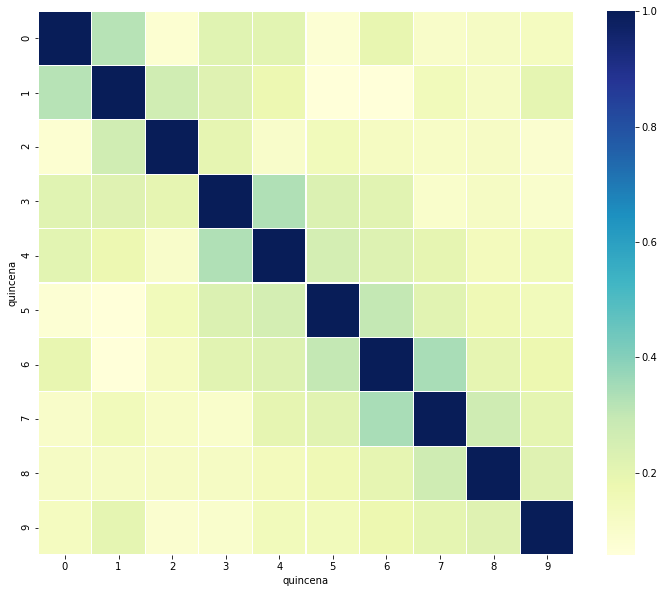

In [21]:

corrmat = datos_tiempo.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, ax=ax, cmap="YlGnBu", linewidths=0.1)

In [22]:
j = 0
for i in datos_tiempo.columns:
    datos_tiempo.rename(columns={j:'max_tiempo_sesion_q_'+str(j)},inplace=True)
    j =  j + 1

In [23]:
datos_tiempo.fillna(0,inplace=True)

In [24]:
datos_tiempo_q = datos[['person','quincena','time_event']]
datos_tiempo_q.fillna(0,inplace=True)
datos_tiempo_q = datos_tiempo_q.groupby(['person','quincena']).agg({'time_event':'mean'})
datos_tiempo_q = datos_tiempo_q.unstack()
datos_tiempo_q.columns = datos_tiempo_q.columns.droplevel(0)
datos_tiempo_q = datos_tiempo_q.reset_index(level=0,drop=False)
j = 0
for i in datos_tiempo_q.columns:
    datos_tiempo_q.rename(columns={j:'prom_tiempo_sesion_q_'+str(j)},inplace=True)
    j =  j + 1

C:\Users\franc\Anaconda3\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [25]:
eventos_x_person = datos[['person','event','quincena','timestamp']]
eventos_x_person = eventos_x_person.groupby(['person','event','quincena']).agg({'timestamp':'count'})
eventos_x_person = eventos_x_person.unstack('event')
eventos_x_person.columns = eventos_x_person.columns.droplevel(0)
eventos_x_person = eventos_x_person.unstack(-1)

In [26]:
p = datos[['person','timestamp']].drop_duplicates('person')

In [27]:
#eventos_x_person.columns = eventos_x_person.columns.droplevel(0)
columnas = {}
for i in datos.event.unique():
    for j in range(0,10):
        columnas[j] = i+'_'+str(j)
    p = pd.merge(p,eventos_x_person[i],on='person',how='left')
    p = p.rename(columns=columnas)
p.drop(columns='timestamp',inplace=True)
p.fillna(0,inplace=True)

In [28]:
eventos_x_person = datos[['person','event','timestamp']]
eventos_x_person = eventos_x_person.groupby(['person','event']).agg({'timestamp':'count'})
eventos_x_person = eventos_x_person.unstack(-1)
eventos_x_person.columns = eventos_x_person.columns.droplevel(0)
eventos_x_person = eventos_x_person.reset_index()
eventos_x_person.fillna(0,inplace=True)

In [29]:
train = pd.read_csv("labels_training_set.csv",low_memory=False)

In [30]:
dat = pd.merge(datos_tiempo,datos_tiempo_q,on='person')
dat.fillna(0,inplace=True)
train = pd.merge(train,dat,on='person',how='inner')

In [31]:
train = pd.merge(train,p,on='person')
train = pd.merge(train,eventos_x_person,on='person')
train = pd.merge(train, sistema_celulares, on="person")

In [32]:
datos.event.unique()

array(['viewed product', 'searched products', 'ad campaign hit',
       'staticpage', 'checkout', 'search engine hit', 'conversion',
       'generic listing', 'brand listing', 'visited site', 'lead'],
      dtype=object)

# IDEAS
-SI compro recientemente

-Hace cuanto no se loggea en la pagina

-Cada cuanto se loguea en la página

-Antiguedad en la pagina



### Features, gap entre compras y etc

Funcion que toma la distancia en dias de una compra y la siguiente sesión

In [33]:
def logueoycompras(df):
    rows=[]
    person = ""
    for index,row in df.iterrows():
        if((row['event'] == 'conversion') & (person == "")):
            dia_conversion = row['timestamp']
            person = row['person']
            continue
        if(person != ""):
            dias = row['timestamp'].timetuple().tm_yday -\
                dia_conversion.timetuple().tm_yday
            if(person!=row['person']):
                dias = datetime(2018, 6, 1, 0, 0).timetuple().tm_yday -\
                        dia_conversion.timetuple().tm_yday
                rows.append([person,dia_conversion.timetuple().tm_yday,dias])
                person = ""
                continue
            if dias >= 1:
                rows.append([person,dia_conversion.timetuple().tm_yday,dias])
                person = ""
    return pd.DataFrame(rows,columns=('person','day_of_year','dias_sin_conversion'))

Funcion que toma el gap entre compras desde registración hasta el 1ro de junio (en días)

In [34]:
def dist_compras(df):
    rows = []
    person = ""
    for index,row in df.iterrows():
        if(person != row['person']):
            if(person != ""):
                gap = (datetime(2018, 6, 1, 0, 0) - dia).total_seconds()
                rows.append([person,dia,gap])
            person = row['person']
            dia = row['timestamp']
        else:
            gap = (row['timestamp'] - dia).total_seconds()
            rows.append([person,dia,gap])
            dia = row['timestamp']
    return pd.DataFrame(rows,columns=('person','timestamp','distance'))

In [35]:
personas = datos[['person','new_vs_returning']]
personas = personas.loc[personas['new_vs_returning'] == 'New']

In [36]:
usuariosyregistros = datos[['person','timestamp']].sort_values(by=['person','timestamp'],ascending = True)\
                                                .drop_duplicates('person').merge(personas,on='person',how='left')                                                                                
print('Sin fecha registro : ',usuariosyregistros.new_vs_returning.isnull().sum())
usuariosyregistros.fillna('New',inplace=True)

Sin fecha registro :  587


In [37]:
datos = pd.merge(datos,usuariosyregistros,how='left',on=['person','timestamp'])
print('Sin registro: ',datos[['person','new_vs_returning_y']].sort_values(by='new_vs_returning_y')\
                                            .drop_duplicates('person').new_vs_returning_y.isnull().sum())
datos = datos.rename(columns={'new_vs_returning_y':'new_vs_returning'}).drop(columns='new_vs_returning_x')

Sin registro:  0


In [38]:
usuariosyregistros.head()

,person,timestamp,new_vs_returning
0,0008ed71,2018-05-17 12:27:47,New
1,00091926,2018-05-03 22:08:29,New
2,00091a7a,2018-03-26 14:51:11,New
3,000ba417,2018-05-17 11:11:45,New
4,000c79fe,2018-05-29 00:27:47,New


In [39]:
compradores = datos[['person','timestamp','event']].sort_values(by=['person','timestamp'])
compradores = compradores.loc[compradores['event']=='conversion',['person','timestamp']]
sesion_comprar = compradores.append(usuariosyregistros)
sesion_comprar =sesion_comprar.reset_index(drop=True)
sesion_comprar.drop(columns='new_vs_returning',inplace=True)
sesion_comprar.sort_values(by=['person','timestamp'],inplace=True)

C:\Users\franc\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [40]:
sesion_comprar['timestamp'] = pd.to_datetime(sesion_comprar['timestamp'])
distancias = dist_compras(sesion_comprar)
distancias['distance']/= (60*60*24)

In [41]:
distancias.head()

,person,timestamp,distance
0,0008ed71,2018-05-17 12:27:47,14.480706
1,00091926,2018-05-03 22:08:29,28.077442
2,00091a7a,2018-03-26 14:51:11,66.381123
3,000ba417,2018-05-17 11:11:45,9.081678
4,000ba417,2018-05-26 13:09:22,5.451829


In [42]:
hace_cuanto_no_convierte = distancias.sort_values(by='timestamp',ascending=False).\
                                            drop_duplicates('person').drop(columns='timestamp').\
                                                rename(columns={'distance':'dias_sin_convertir'})
max_sin_convertir = distancias[['person','distance']].groupby('person').max().reset_index().\
                                                    rename(columns={'distance':'max_sin_convertir'})
promedio_dias_conversion = distancias[['person','distance']].groupby('person').mean().reset_index().\
                                                    rename(columns={'distance':'convierte_cada_x_dias'})

In [43]:
personas = datos[['person','timestamp','new_vs_returning']]
personas = personas.loc[personas['new_vs_returning'] == 'New']
personas['registration_day'] = personas['timestamp'].dt.dayofyear
personas.drop(columns=['new_vs_returning','timestamp'],inplace=True)
personas.drop_duplicates('person',inplace=True)

In [44]:
new_columns_days = pd.merge(personas,max_sin_convertir,how='left',on='person')
new_columns_days = pd.merge(new_columns_days,hace_cuanto_no_convierte,how='left',on='person')
new_columns_days.loc[(new_columns_days['max_sin_convertir'].isnull()) | (new_columns_days['dias_sin_convertir'].\
            isnull()),['max_sin_convertir','dias_sin_convertir']] = 152 - new_columns_days['registration_day']
new_columns_days = pd.merge(new_columns_days,promedio_dias_conversion,how='left',on='person')
new_columns_days.fillna(0,inplace=True)


In [45]:
new_columns_days.isnull().sum()

person                   0
registration_day         0
max_sin_convertir        0
dias_sin_convertir       0
convierte_cada_x_dias    0
dtype: int64

In [46]:
new_columns_days['registration_day'] = datetime(2018, 6, 1, 0, 0).timetuple().tm_yday\
                                                                        - new_columns_days['registration_day']
new_columns_days.rename(columns={'registration_day':'antiguedad'},inplace=True)
train = pd.merge(train,new_columns_days,on='person')

In [47]:
datos_sesiones_q = datos[['person','quincena','new_vs_returning']]
datos_sesiones_q.fillna(0,inplace=True)
datos_sesiones_q.loc[(datos_sesiones_q['new_vs_returning'] == 'New') |\
                                     (datos_sesiones_q['new_vs_returning'] == 'Returning'),'new_vs_returning'] = 1
datos_sesiones_q = datos_sesiones_q.groupby(['person','quincena']).agg({'new_vs_returning':'sum'})
datos_sesiones_q = datos_sesiones_q.unstack()
datos_sesiones_q.columns = datos_sesiones_q.columns.droplevel(0)
datos_sesiones_q = datos_sesiones_q.reset_index(level=0,drop=False)
datos_sesiones_q.fillna(0,inplace=True)

j = 0
for i in datos_sesiones_q.columns:
    datos_sesiones_q.rename(columns={j:'cant_sesiones_q_'+str(j)},inplace=True)
    j =  j + 1

C:\Users\franc\Anaconda3\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\franc\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [48]:
train = pd.merge(train,datos_sesiones_q,on='person')

In [49]:
train.isnull().sum()

person                    0
label                     0
max_tiempo_sesion_q_0     0
max_tiempo_sesion_q_1     0
max_tiempo_sesion_q_2     0
max_tiempo_sesion_q_3     0
max_tiempo_sesion_q_4     0
max_tiempo_sesion_q_5     0
max_tiempo_sesion_q_6     0
max_tiempo_sesion_q_7     0
max_tiempo_sesion_q_8     0
max_tiempo_sesion_q_9     0
prom_tiempo_sesion_q_0    0
prom_tiempo_sesion_q_1    0
prom_tiempo_sesion_q_2    0
prom_tiempo_sesion_q_3    0
prom_tiempo_sesion_q_4    0
prom_tiempo_sesion_q_5    0
prom_tiempo_sesion_q_6    0
prom_tiempo_sesion_q_7    0
prom_tiempo_sesion_q_8    0
prom_tiempo_sesion_q_9    0
viewed product_0          0
viewed product_1          0
viewed product_2          0
viewed product_3          0
viewed product_4          0
viewed product_5          0
viewed product_6          0
viewed product_7          0
                         ..
lead_6                    0
lead_7                    0
lead_8                    0
lead_9                    0
ad campaign hit     

In [50]:
features = train.iloc[:,2:].columns

In [51]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,\
                             GradientBoostingClassifier, ExtraTreesClassifier,\
                             BaggingClassifier, VotingClassifier)
rnd_clf = RandomForestClassifier(n_estimators = 100 , criterion = 'entropy',random_state = 0)
rnd_clf.fit(train.iloc[:,2:],train['label'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [52]:
for name, importance in zip(features, rnd_clf.feature_importances_):
    print('"' + name + '"'+" : ",importance,',')

"max_tiempo_sesion_q_0" :  0.0013903411434297765 ,
"max_tiempo_sesion_q_1" :  0.001304420761197562 ,
"max_tiempo_sesion_q_2" :  0.001767420370156364 ,
"max_tiempo_sesion_q_3" :  0.001743718468788529 ,
"max_tiempo_sesion_q_4" :  0.005045811938263046 ,
"max_tiempo_sesion_q_5" :  0.006261637804513105 ,
"max_tiempo_sesion_q_6" :  0.008157661739056762 ,
"max_tiempo_sesion_q_7" :  0.007492200697493777 ,
"max_tiempo_sesion_q_8" :  0.010589239090459184 ,
"max_tiempo_sesion_q_9" :  0.032427149051712484 ,
"prom_tiempo_sesion_q_0" :  0.0009541998143873034 ,
"prom_tiempo_sesion_q_1" :  0.0021207128115396045 ,
"prom_tiempo_sesion_q_2" :  0.0014254214658186827 ,
"prom_tiempo_sesion_q_3" :  0.001800372980063727 ,
"prom_tiempo_sesion_q_4" :  0.0041678083888307595 ,
"prom_tiempo_sesion_q_5" :  0.005866926695387883 ,
"prom_tiempo_sesion_q_6" :  0.006718295460324727 ,
"prom_tiempo_sesion_q_7" :  0.0064097917271120075 ,
"prom_tiempo_sesion_q_8" :  0.011885570231522813 ,
"prom_tiempo_sesion_q_9" :  0.03354

Features más importantes

In [60]:
for name, importance in zip(features, rnd_clf.feature_importances_):
    if(importance > 0.01):
        print('"' + name + '"'+" : ",importance,',')

"max_tiempo_sesion_q_8" :  0.010589239090459184 ,
"max_tiempo_sesion_q_9" :  0.032427149051712484 ,
"prom_tiempo_sesion_q_8" :  0.011885570231522813 ,
"prom_tiempo_sesion_q_9" :  0.03354320193230159 ,
"viewed product_9" :  0.030836135223204407 ,
"searched products_9" :  0.015231746595320965 ,
"ad campaign hit_9" :  0.017659155426005917 ,
"checkout_9" :  0.05694951340404678 ,
"search engine hit_9" :  0.015833442189111063 ,
"generic listing_9" :  0.018286419661136703 ,
"brand listing_9" :  0.016092254783926115 ,
"visited site_9" :  0.021545635772851894 ,
"ad campaign hit" :  0.023958683278695322 ,
"brand listing" :  0.025549112506246564 ,
"checkout" :  0.0462511515367464 ,
"generic listing" :  0.022796781058908127 ,
"search engine hit" :  0.020605347094283234 ,
"searched products" :  0.01915325009991306 ,
"viewed product" :  0.035740553224287465 ,
"visited site" :  0.02444790604451424 ,
"antiguedad" :  0.03587347131668364 ,
"max_sin_convertir" :  0.04948456101327431 ,
"dias_sin_convertir

In [61]:
train.to_csv('train_final.csv', encoding='utf-8', index=False)

PermissionError: [Errno 13] Permission denied: 'train_final.csv'

In [63]:
test = pd.read_csv("trocafone_kaggle_test.csv",low_memory=False)
test = pd.merge(test,dat,on='person')
test = pd.merge(test,p,on='person')
test = pd.merge(test,new_columns_days,on='person')
test = pd.merge(test,datos_sesiones_q,on='person')
test = pd.merge(test,eventos_x_person,on='person')
test = pd.merge(test, sistema_celulares, on='person')

In [64]:
test.to_csv('test_final.csv', encoding='utf-8', index=False)